In [1]:
import sys

base_path = '/tf/eipi10/qbz95'
sys.path.append(base_path)

from qbz95 import config
import pandas as pd
config = config.get_config('jupyter')
pd.set_option('display.width', 1000)

%matplotlib inline

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

# #当module有新的方法的时候，需要运行下面方法。
# %reload_ext autoreload


2020-10-23 03:26:06,406: INFO: deployment = local_wechat
2020-10-23 03:26:06,407: INFO: base_path = /home/grid/eipi10/qbz95/qbz95
2020-10-23 03:26:06,407: INFO: data_path = /home/grid/eipi10/qbz95/data
2020-10-23 03:26:06,812: INFO: deployment = jupyter
2020-10-23 03:26:06,813: INFO: base_path = /tf/eipi10/qbz95/qbz95
2020-10-23 03:26:06,813: INFO: data_path = /tf/eipi10/qbz95/data


In [2]:
import logging
import tensorflow as tf
import time
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)


class TaskTime:
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))

def lenet(in_dim=1, n_class=10):
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, in_dim)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(n_class))    
    return model

--------------------------------------------------
创建模型
--------------------------------------------------
显示参数
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
__________

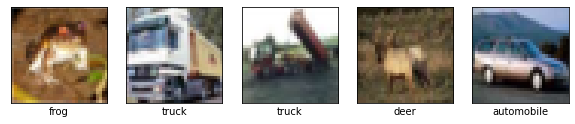

In [3]:
print("-"*50 + "\n创建模型") 
model = lenet(in_dim=3, n_class=10)

print("-"*50 + "\n显示参数")
model.summary()

print("-"*50 + "\n获取数据"
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

print(train_images.shape, train_labels.shape, train_images.shape, test_labels.shape)
print(type(train_images), type(train_labels.shape))

print("-"*50 + "\n显示图片示例")
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

2020-10-23 05:07:12,683: INFO: start training


--------------------------------------------------
训练模型
Epoch 1/10
1563/1563 [==============================] - 5s 4ms/step - loss: 1.6112 - accuracy: 0.4141 - val_loss: 1.4239 - val_accuracy: 0.4871
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.3356 - accuracy: 0.5201 - val_loss: 1.2624 - val_accuracy: 0.5430
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2272 - accuracy: 0.5610 - val_loss: 1.2615 - val_accuracy: 0.5476
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1500 - accuracy: 0.5932 - val_loss: 1.1808 - val_accuracy: 0.5846
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0852 - accuracy: 0.6159 - val_loss: 1.1356 - val_accuracy: 0.6028
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0290 - accuracy: 0.6372 - val_loss: 1.1067 - val_accuracy: 0.6036
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.98

2020-10-23 05:08:08,415: INFO: finish training [elapsed time: 55.73 seconds]


--------------------------------------------------
保存，加载模型
--------------------------------------------------
评估模型
1563/1563 - 3s - loss: 0.8029 - accuracy: 0.7178
313/313 - 1s - loss: 1.0749 - accuracy: 0.6277
Train Accuracy: 71.8%, Test Accuracy: 62.8%


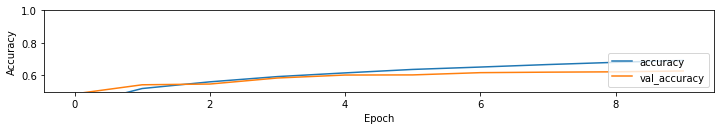

In [22]:
print("-"*50 + "\n训练模型")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
with TaskTime('training', True):
    history = model.fit(train_images, train_labels, epochs=10, batch_size=32,
                        validation_data=(test_images, test_labels))

print("-"*50 + "\n保存，加载模型") 
model.save('model/tf_lenet.h5') 
model = tf.keras.models.load_model('model/tf_lenet.h5')  
    
print("-"*50 + "\n评估模型")    
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

train_loss, train_acc = model.evaluate(train_images,  train_labels, verbose=2)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('Train Accuracy: {:0.1f}%, Test Accuracy: {:0.1f}%'.format(100 * train_acc, 100*test_acc)) 

In [19]:
model.save('model/tf_lenet.h5') 
model = tf.keras.models.load_model('model/tf_lenet.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

--------------------------------------------------
评估模型
1563/1563 - 3s - loss: 0.8132 - accuracy: 0.7107
313/313 - 1s - loss: 1.1250 - accuracy: 0.6165
Train Accuracy: 71.1%, Test Accuracy: 61.7%


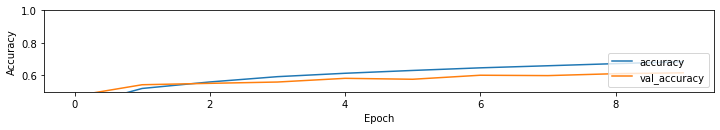

In [20]:
print("-"*50 + "\n评估模型")    
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

train_loss, train_acc = model.evaluate(train_images,  train_labels, verbose=2)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('Train Accuracy: {:0.1f}%, Test Accuracy: {:0.1f}%'.format(100 * train_acc, 100*test_acc))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


RuntimeError: Virtual devices cannot be modified after being initialized